# Проект: классификация

In [686]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import RFE
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

#### **Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

#### **Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

#### **Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её необходимо предсказать.

### Задание 1

In [611]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [612]:
# исследуем данные на предмет пропусков. 
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [613]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [614]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(' ', '').str.replace(',00', '').str.replace('$', '')
df['balance']= df['balance'].astype(float)

In [615]:
#Вычислим среднее значение по преобразованному в корректный вид признаку balance
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [616]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [617]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [618]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].str.replace('unknown', df['job'].mode()[0])

In [619]:
df['job'].value_counts()
#замена unknown профессии модальным значением признака дало увеличение самой популярной профессии management на 70 

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [620]:
#Теперь сделаем то же самое для признака education
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [621]:
df['education'] = df['education'].str.replace('unknown', df['education'].mode()[0])
df['education'].value_counts()
#аналогично увеличили модальное значение признака на количество unknown строк

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [622]:
round(df[(df['education'] == 'secondary') & (df['job'] == 'management')]['balance'].mean(),3)

1598.883

### Задание 6

In [623]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound
outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Верхняя граница по методу Тьюки: {round(upper_bound)}')
print(f'Нижняя граница по методу Тьюки: {round(lower_bound)}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница по методу Тьюки: 4063
Нижняя граница по методу Тьюки: -2241


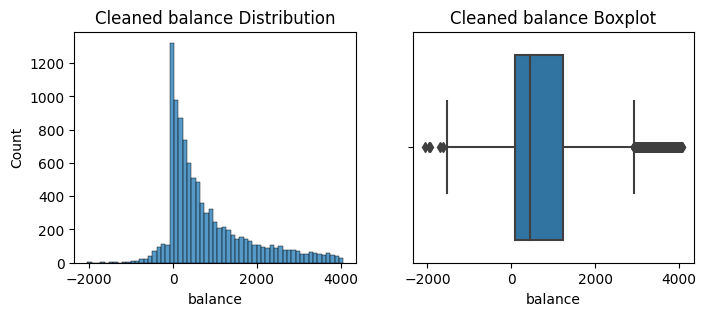

In [624]:
#Визуализируем для наглядности
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned balance Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned balance Boxplot');

In [625]:
# удалим все выбросы для признака balance, которые лежат за пределами верхней и нижней границы по методу Тьюки:
df = df[(df['balance'] >= -2241) & (df['balance'] <= 4063)]
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [626]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируем результат
df['deposit'].value_counts()


no     5424
yes    4681
Name: deposit, dtype: int64

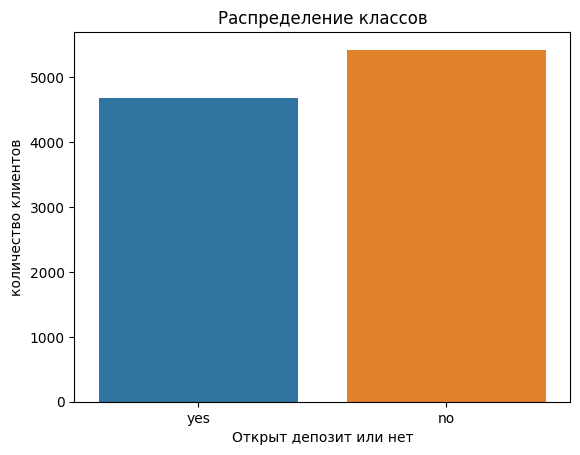

In [627]:
ax = sns.countplot(df, x=df['deposit'])
ax.set(xlabel='Открыт депозит или нет', ylabel='количество клиентов')
ax.set_title('Распределение классов');

Есть небольшой дисбаланс в соотношении классов(клиентов открывших и неоткрывших депозит)

### Задания 2 и 3

In [628]:
#посмотрим описательную статистику для количественных переменных, проинтерпретируем результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'balance'}>,
        <AxesSubplot: title={'center': 'day'}>],
       [<AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'campaign'}>,
        <AxesSubplot: title={'center': 'pdays'}>],
       [<AxesSubplot: title={'center': 'previous'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

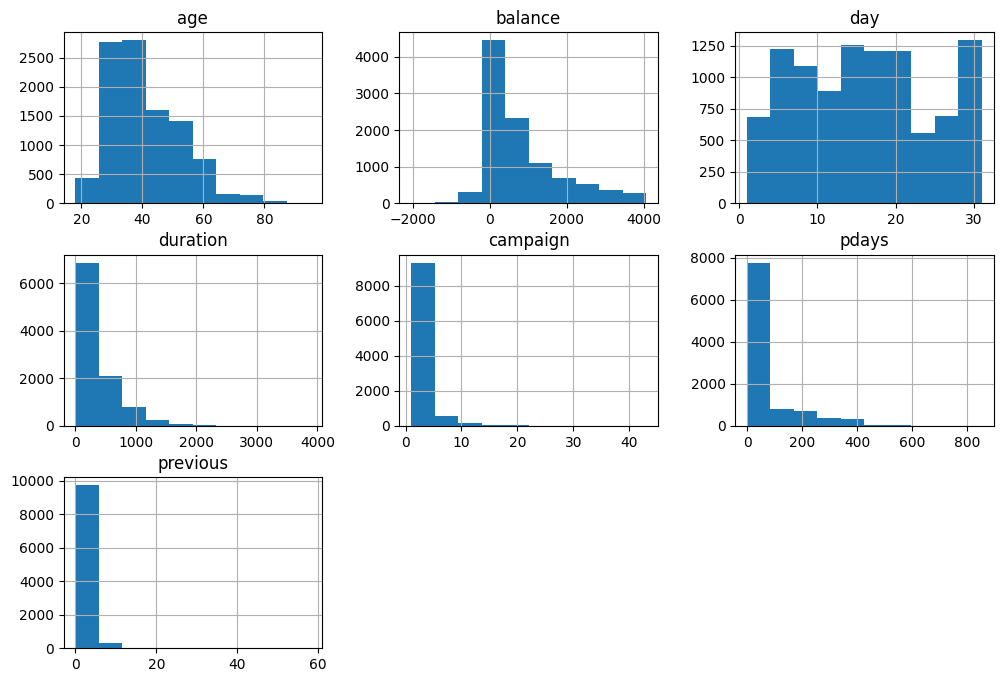

In [629]:
#Посмотрим на распределение числовых признаков с помощью гисторграммы
df.hist(figsize=(12,8))

<AxesSubplot: xlabel='previous', ylabel='deposit'>

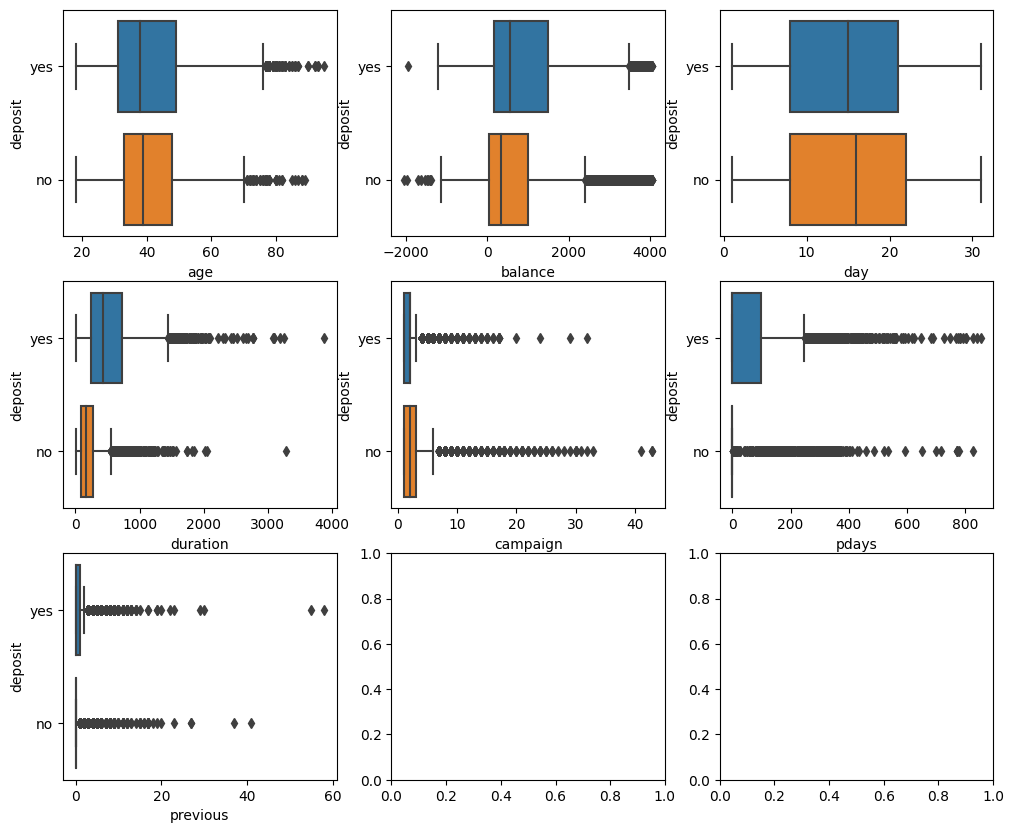

In [630]:
#А теперь посмотрим на потенциальные выбросы в числовых признаках с помощью коробчатой диаграммы, в разрезе открыт ли у клиента депозит
fig, ax = plt.subplots(3,3, figsize=(12,10))
sns.boxplot(df, x='age', y='deposit', ax=ax[0,0]) 
sns.boxplot(df, x='balance', y='deposit', ax=ax[0,1])
sns.boxplot(df, x='day', y='deposit', ax=ax[0,2])
sns.boxplot(df, x='duration', y='deposit', ax=ax[1,0])
sns.boxplot(df, x='campaign', y='deposit', ax=ax[1,1])
sns.boxplot(df, x='pdays', y='deposit', ax=ax[1,2])
sns.boxplot(df, x='previous', y='deposit', ax=ax[2,0])

In [631]:
df['pdays'].value_counts(normalize=True)[:5]

-1      0.748936
 92     0.008709
 182    0.007620
 181    0.007422
 91     0.007323
Name: pdays, dtype: float64

С помощью описательной статистики и простой визуализации можно увидеть первые зависимости и сделать некоторые выводы:
1. Распределение признаков отлично от нормального, большинство имеют правостороннюю ассиметрию. Только признаки age и balance имееют приблизительно нормальное распределение. У признаком много анаиальных выбросов.
2. Признак age скорее всего содержит выбросы, максимальный возраст клиента 95 лет, и такое ,конечно, может быть,  но надо проверить. Средний возраст клиентов в диапазоне 35-40 лет. Большенство вкладов открыто клиентами возрастом 35-50 лет.
3. Два признака имеют отрицательные значения. Один из них - признак balance, и это вполне допустимо, т к может быть долг по счету, вопрос только по клиенту с отрицательным балансом, при этом имеющим депозит, это уже сомнительно. Второй признак - pdays - количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании. Имеет отрицательное значение, равное -1, причем 75% данных имеют это значение. Что означает данное значение необходимо выяснить.
4. Сразу в глаза бросается максимальное значение продолжительности контакта (duration), длящийся 65 минут. Либо это был очень эффективный разговор, либо это выброс. А еще здесь в принципе прослеживается прямая закономерность: проделанная работа дает результат, чем больше длился контакт с клиентом, тем больше вероятность открытия депозита. Об этом же свидетельствует признак previous - количество контактов до текущей кампании.
5. Любопытно, что большинство контактов в текущей маркетинговой компании приходятся на середину месяца, с 8 по 22 число месяца, это может дать понимание эффективности контактов, обусловленной некой "сезонностью", а скорее всего загруженностью в начале и в конце месяца и неготовностью клиентов идти на контакт.

### Задания 4 и 5

In [632]:
#Теперь рассмотрим категориальные переменных, проинтерпретируем результат
df.describe(include=object)

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Сразу видим большое количество уникальный значений признака job (сферы занятости клиента), а также бросается в глаза три уникальных значения признака "семейное положение", для дальнейшей работы скорее всего необходимо преобразовать до бинарного: да, нет. Также в признаке poutcome (результат прошлой маркетинговой кампании) самое распространенное значение - unknown.

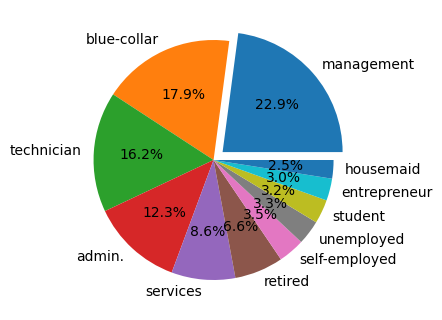

In [633]:
#Для начала посмотрим соотношение различных сфер деятельности 
jobs = df['job'].value_counts()
fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    jobs,
    labels=jobs.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

Text(0, 0.5, 'Количество клиентов')

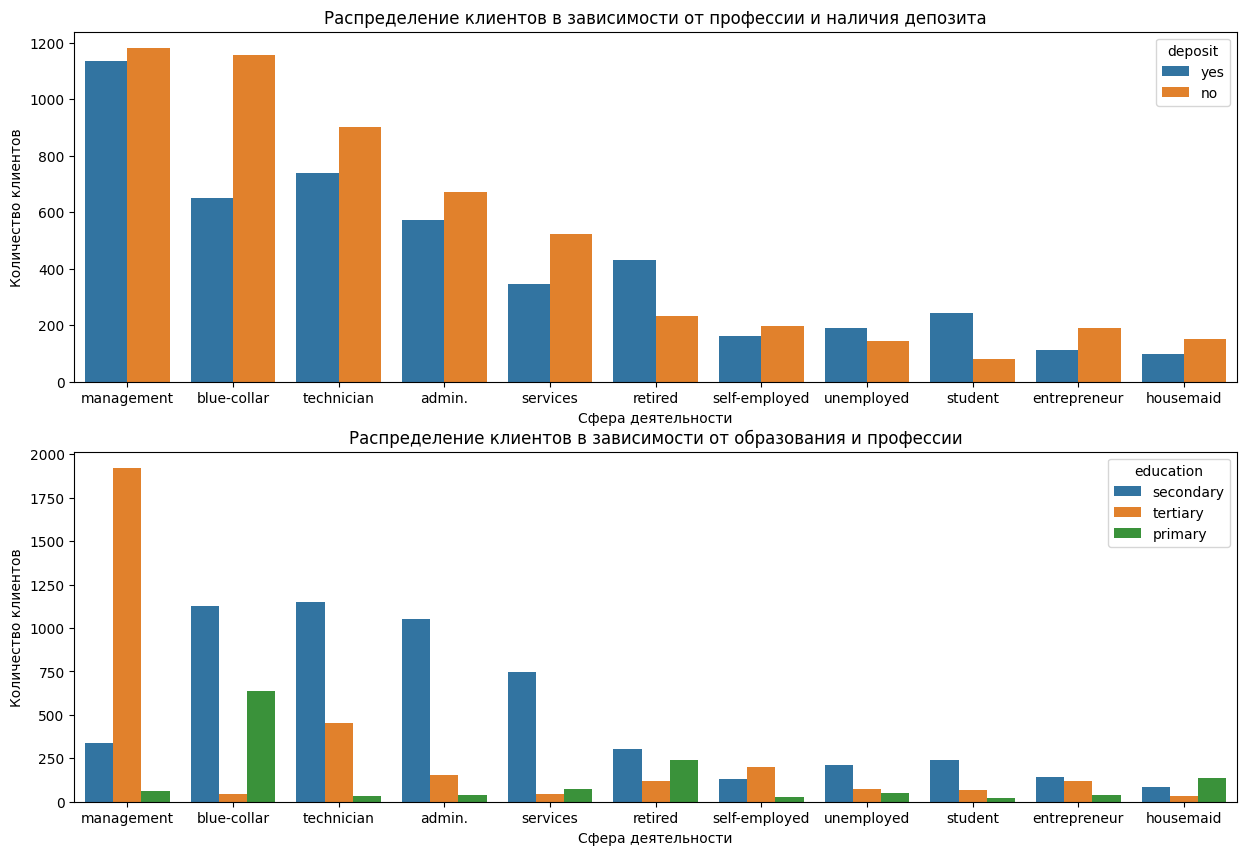

In [634]:
# А теперь посмотрим на распределение наличия депозита в зависимости от профессии и образования
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
sns.countplot(
    data=df, x='job', hue='deposit', 
    order=df['job'].value_counts().index, ax=ax[0]
)
ax[0].set_title('Распределение клиентов в зависимости от профессии и наличия депозита')
ax[0].set_xlabel('Сфера деятельности')
ax[0].set_ylabel('Количество клиентов')

sns.countplot(
    data=df, x='job', hue='education', 
    order=df['job'].value_counts().index, ax=ax[1]
)
ax[1].set_title('Распределение клиентов в зависимости от образования и профессии')
ax[1].set_xlabel('Сфера деятельности')
ax[1].set_ylabel('Количество клиентов')

Логично, что такие признаки, как образование и сфера деятельности являются информативными и имеют прямую зависимость с целевой переменной, так как эти фактору, как правило, напрямую влияют на уровень дохода клиента и соответственнно на вероятность открытия вклада в банке. Самая распространенная сфера деятельности - менеджмент. Клиенты из этой сферы в своем большинстве имеют высшее образование и больше всего депозитов в банке. Далее по нисходящей идет рабочий класс(blue-collar), в большинстве своем со средним и начальным образованием, которые чаще не открывают депозит, чем открывают. Возможно, для банка это может стать потенциальной возможностью роста, той упущенной возможностью в результате недоработки с этой категорией клиентов. Большинство клиентов банка имеют среднее образование.

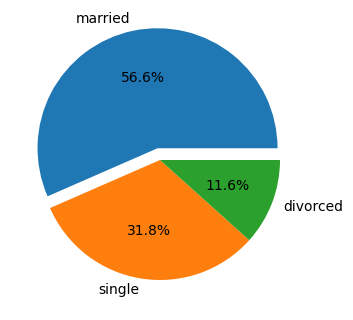

In [635]:
#Для начала посмотрим соотношение различных сфер деятельности 
marriage = df['marital'].value_counts()
fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    marriage,
    labels=marriage.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0]
);

<AxesSubplot: xlabel='marital', ylabel='count'>

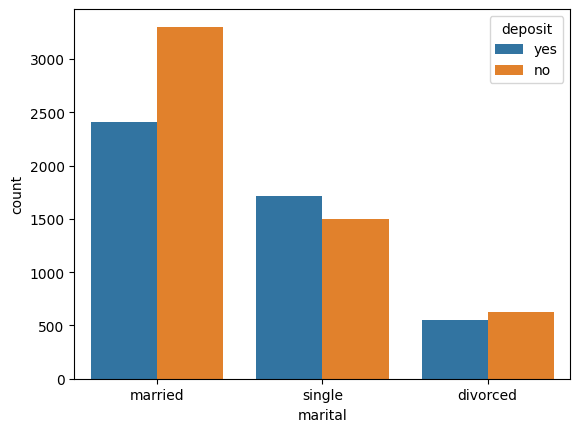

In [636]:
sns.countplot(
    data=df, x='marital', hue='deposit', 
    order=df['marital'].value_counts().index
)

Больше половины клиентов находятся в браке, большинство из которых не имеют депозита. Противоположная ситуация для клиентов, которые не в браке, и примерно 50/50 для разведенных. И тут возникает вопрос: это остутствие свободных средств, обусловленное наличием семьи или же это плохая эффективность последней кампании по привлечению средств в депозиты?

Text(0, 0.5, 'Количество клиентов')

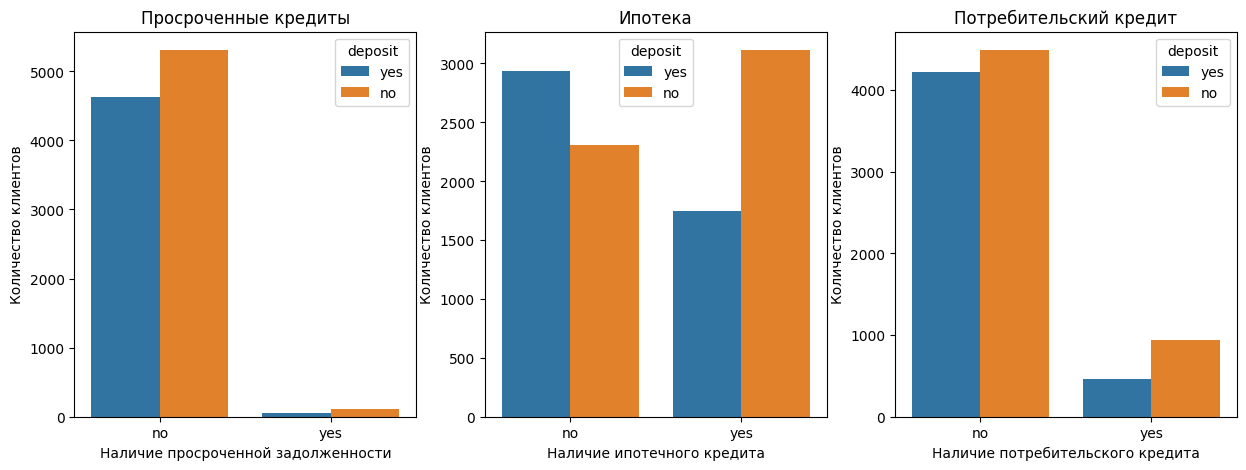

In [637]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.countplot(
    df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[0]
)
ax[0].set_title('Просроченные кредиты')
ax[0].set_xlabel('Наличие просроченной задолженности')
ax[0].set_ylabel('Количество клиентов')
sns.countplot(
    df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[1]
)
ax[1].set_title('Ипотека')
ax[1].set_xlabel('Наличие ипотечного кредита')
ax[1].set_ylabel('Количество клиентов')
sns.countplot(
    df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[2]
)
ax[2].set_title('Потребительский кредит')
ax[2].set_xlabel('Наличие потребительского кредита')
ax[2].set_ylabel('Количество клиентов')

In [638]:
df_free = df[(df['housing'] == 'no') & (df['loan'] == 'no')]
df_free['deposit'].value_counts(normalize=True)

yes    0.586526
no     0.413474
Name: deposit, dtype: float64

Сразу хочется отметить, что доля клиентов с просроченной задолженностью в банке очень мала. Также мы видим, что банк чаще выдает ипотечные кредиты, нежели потребительские. Клиенты, которые не имеют ипотеки, открывают депозиты чаще, что понятно, т к отсутствует кредитная нагрузка и возможна вероятность наличия свободных средств. Среди клиентов, которые не обременены кредитами, доля, открывших вклад, составляет 58%, это конечно не мало, но есть куда расти.

In [639]:
pivot_month = df.groupby('month')['deposit'].value_counts().sort_values(ascending=False)
pivot_month.head()

month  deposit
may    no         1776
       yes         841
jul    no          836
aug    no          775
       yes         610
Name: deposit, dtype: int64

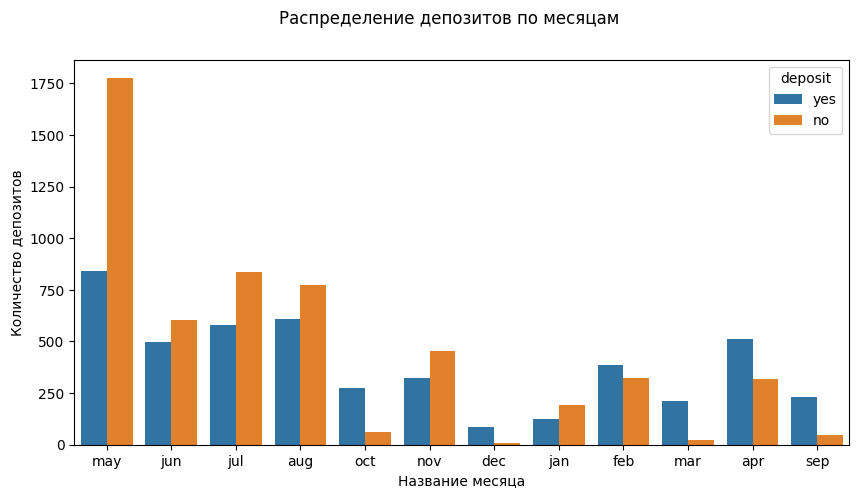

In [640]:
fig = plt.figure(figsize=(10,5))
sns.countplot(
    df,
    x='month',
    hue='deposit',
    orient=df['month'].value_counts().index
)
plt.suptitle('Распределение депозитов по месяцам')
plt.xlabel('Название месяца')
plt.ylabel('Количество депозитов');


<Figure size 1000x700 with 0 Axes>

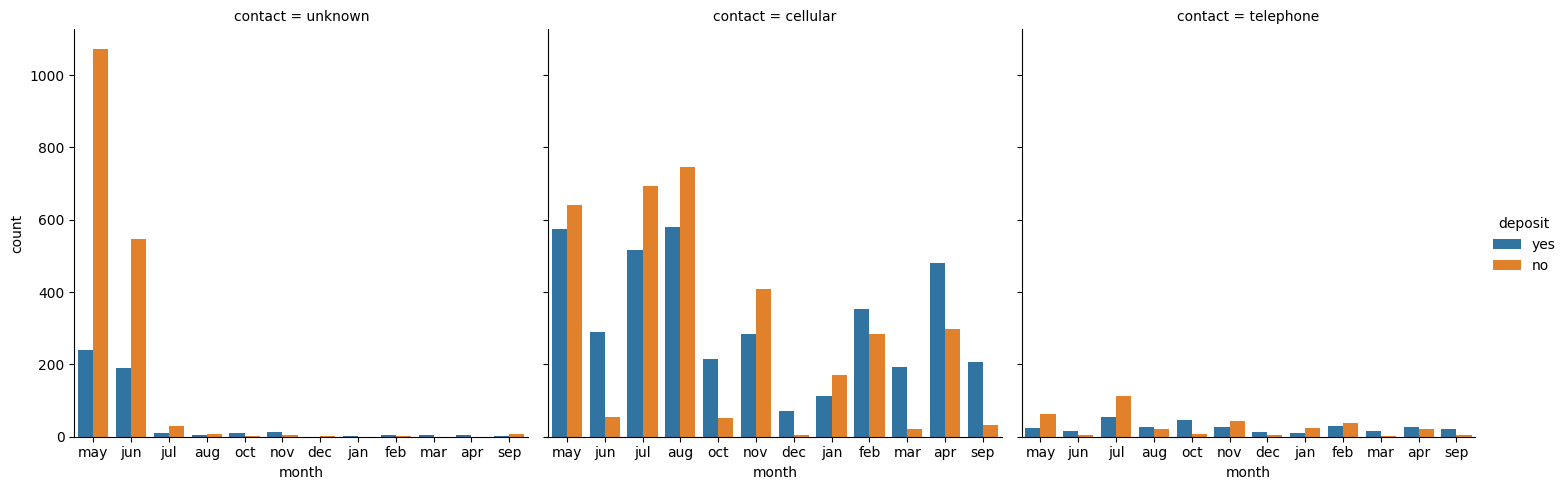

In [641]:
fig = plt.figure(figsize=(10,7))
sns.catplot(
    df,
    x = 'month', 
    hue = 'deposit', 
    col = 'contact', 
    kind = 'count'
    )



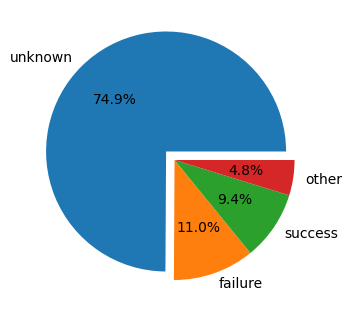

In [642]:
outcome = df['poutcome'].value_counts()
fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    outcome,
    labels=outcome.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0]
);

In [643]:
success_df = df[df['poutcome'] == 'success']

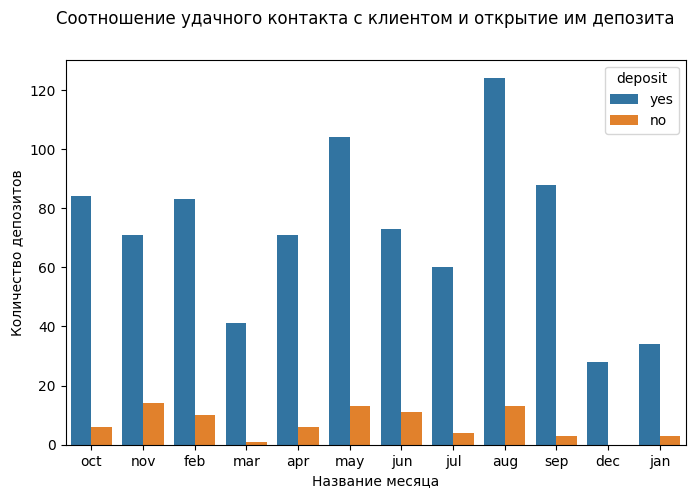

In [644]:
fig = plt.figure(figsize=(8,5))
sns.countplot(
    success_df,
    x='month',
    hue='deposit',
    orient=success_df['month'].value_counts().index
)
plt.suptitle('Соотношение удачного контакта с клиентом и открытие им депозита')
plt.xlabel('Название месяца')
plt.ylabel('Количество депозитов');

Теперь постараемся сделат предварительные выводы по результатам прошлой маркетинговой кампании:
1. Больше всего депозитов было открыто в мае (но и количество отказов в этом месяце велико), на втором месте - июль и август. 
2. У нас есть три типа констакта с клиентом: по телефону, по сотовому телефону и неизвестный (возможно это просто входящий поток, потому что в результате этого типа контакта есть открытые депозиты). Самый эффективный тип взаимодействия с клиентом - сотовый телефон. Именно он принес самый большой результат открытия банковский депозитов, в апреле, мае, июле и августе. Что говорит о том, что данный признак имеет большое значение для определения вероятности открытия вклада.
3. Результат последней маркетинговой кампании определяется всего лишь 9% успеха, а о 75% результата нам ничего не известно. И даже успешное взаимодействие с клиентом не означает 100%-ное открытие депозита.
4. Самые неэффективные месяцы: декабрь и январь, что логично объясняется окончанием текущего года и началом нового. Фактор вполне понятный, но можно воспользоваться этим знанием, и например, не тратить ресурсы и не проводить кампанию в эти месяцы.

### Задание 6

In [645]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
pivot_poutcome = df.groupby('poutcome')['deposit'].value_counts()
pivot_poutcome

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

В группе, которая имела успех в последней маркетинговой компании, количество клиентов, согласившихся открыть депозит, превалирует над отказавшимися.

### Задание 7

In [646]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby('month')['deposit'].value_counts().unstack().sort_values('no', ascending=False)[:1]

deposit,no,yes
month,,
may,1776,841


Больше всего отказов было в мае

### Задание 8

In [647]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
#Создадим функцию, определяющую возрастную категорию клиентов
def cat_age(x):
    if x <= 30:
        return 0
    elif 30 < x <= 40: 
        return 1
    elif 40 < x <= 50: 
        return  2
    elif 50 < x <= 60:
        return 3
    else:
        return 4

#Создадим новый признак 
df['cat_age'] = df['age'].apply(cat_age)
#Выясним какая категория клиентов больше склонна к открытию депозитов
pivot_age = df.groupby('cat_age')['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
pivot_age
    

deposit,no,yes
cat_age,,
1,2215,1627
0,819,1051
2,1360,895
3,933,692
4,97,416


<AxesSubplot: title={'center': 'Распределение открытых/не открытых депозитов для каждой возрастной группы'}, xlabel='cat_age'>

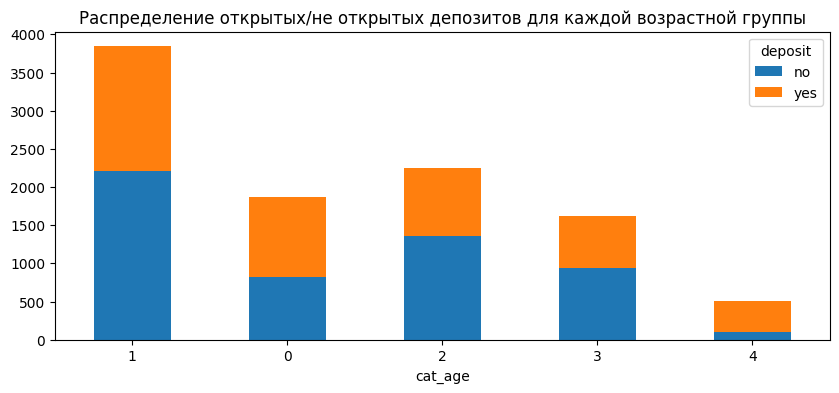

In [648]:
pivot_age.plot.bar(rot = 0, 
                   stacked = True, 
                   figsize=(10, 4), 
                   title = 'Распределение открытых/не открытых депозитов для каждой возрастной группы'
                   )

Возрастным категориям меньше 30 лет и старше 60 свойственно чаще окрывать депозит, чем не открывать. Однако стоит отметить, несмотря на то, что клиенты в возрасте от 30 до 40 лет чаще отказываются от предложения разместить средства в банке, на их долю приходится самое  большое количество открытых вкладов.

### Задания 9 и 10

<Figure size 1000x700 with 0 Axes>

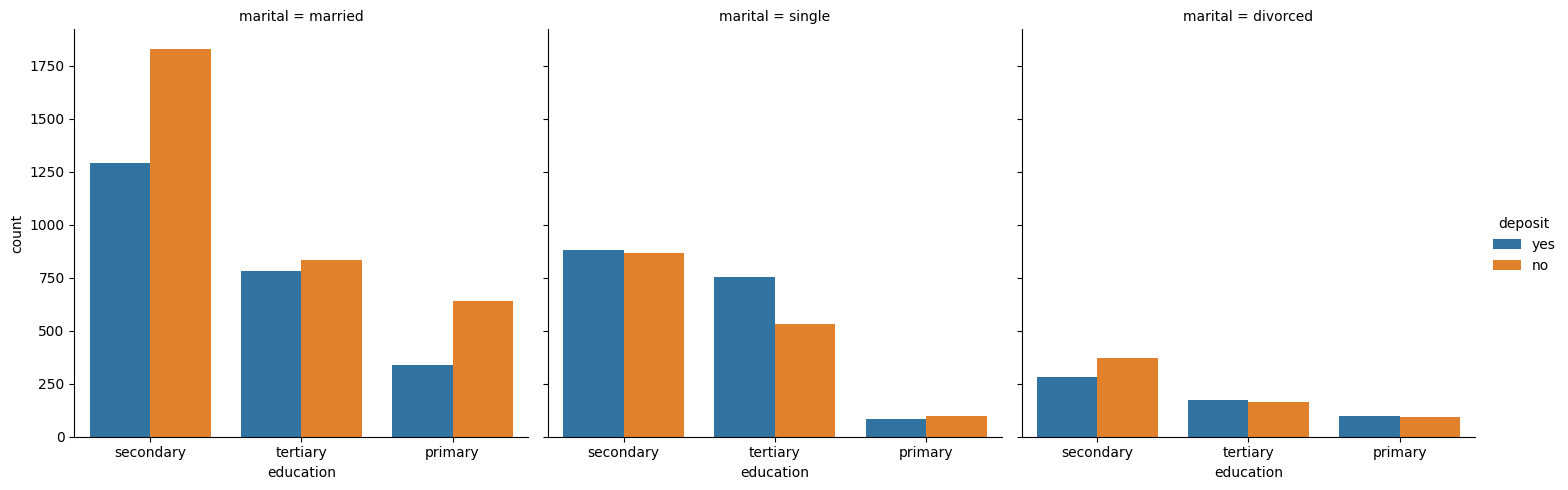

In [649]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса и уровня образования
fig = plt.figure(figsize=(10,7))
sns.catplot(
    df,
    x = 'education', 
    hue = 'deposit', 
    col = 'marital', 
    kind = 'count'
    )

In [650]:
pivot_job = df.groupby('job')['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
pivot_job

deposit,no,yes
job,,
management,1180,1135
technician,900,738
blue-collar,1155,652
admin.,672,574
retired,231,432
services,523,345
student,81,245
unemployed,143,189
self-employed,197,161


<AxesSubplot: title={'center': 'Распределение открытых/не открытых депозитов в зависимости от сферы деятельности'}, xlabel='Сфера деятельности'>

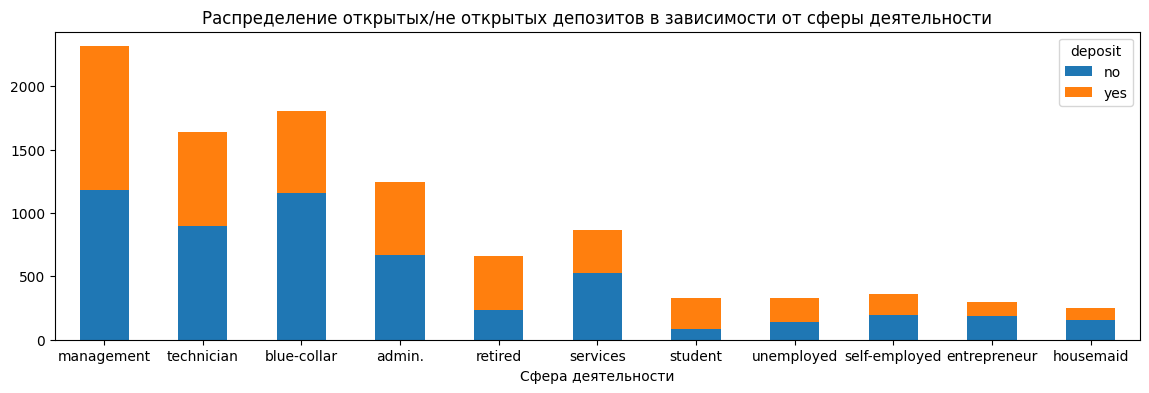

In [651]:
#Построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
pivot_job.plot.bar(rot = 0, 
                   stacked = True, 
                   figsize=(14, 4), 
                   title = 'Распределение открытых/не открытых депозитов в зависимости от сферы деятельности',
                   xlabel = 'Сфера деятельности'
                   )

Как мы видим из графиков выше в сфере менеджмента занято самое большое число клиентов банка, на них же приходится самое большое количество открытых депозитом и практическое такое же число отказов от предложения банка.
Также на клиентов, состоящих в браке и имеющих среднее образование, приходится самое большое количество открытых вкладов, но именно эта категория клиентов чаще всего не открывает депозит, в отличии от клиентов, не состоящих в браке, вне зависимости от уровня образования. Эти клиенты чаще всего склонны принимать положительное решение.

### Задание 11

In [652]:
# Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot = df.groupby(['marital', 'education'])['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
pivot

deposit               no   yes
marital  education            
married  secondary  1830  1289
single   secondary   866   879
married  tertiary    832   784
single   tertiary    531   755
married  primary     641   339
divorced secondary   370   283
         tertiary    163   174
         primary      91    96
single   primary     100    82

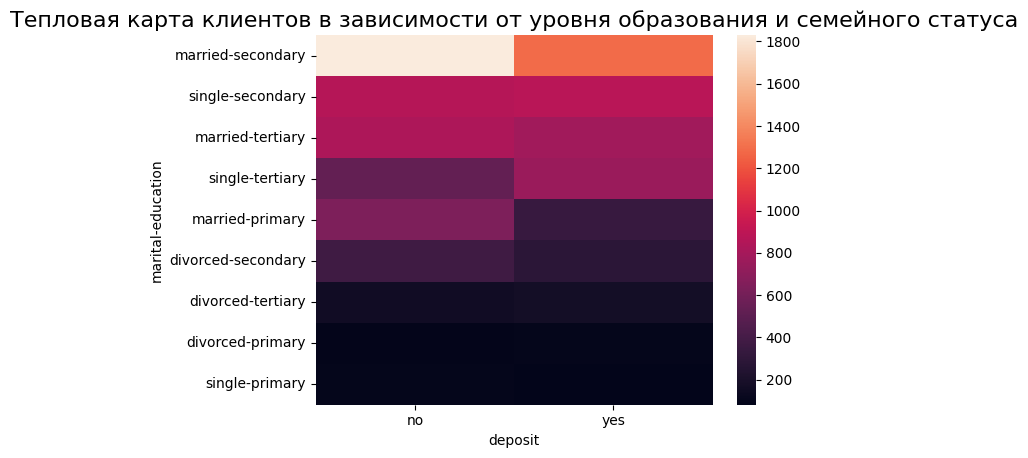

In [653]:
heatmap = sns.heatmap(data=pivot)
heatmap.set_title('Тепловая карта клиентов в зависимости от уровня образования и семейного статуса', fontsize=16);

Видим, как и ранее, преобладание семейных клиенты со средним образованием в двух категориях (открывших и неоткрывших депозит), что говорит нам о том, что это основной фокус банка.

## Часть 3: преобразование данных

Следующим этапом подготовки данных является масштабирование и трансформировация некоторых признаков для того, чтобы улучшить качество нашей будущей модели.

### Задание 1

In [654]:
# Начнем с преобразования уровня образования
LE=LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [655]:
# Преобразуем бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
round(df['deposit'].std(),3)

0.499

In [656]:
round((df['default'].mean() + df['housing'].mean() + df['loan'].mean()),3)

0.635

### Задание 4

In [657]:
# Теперь преобразовуем номинальные переменные, которые могут принимать несколько различных значений. Для ётого создадим дамми-переменные
df = pd.get_dummies(df, columns=['job','marital','contact','month','poutcome'])

In [658]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  cat_age            10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

Не забываем о том, что при искользовании кодировщика det_dummies() исходные столбцы 'job','marital','contact','month','poutcome' удаляются.

### Задания 5 и 6

<AxesSubplot: >

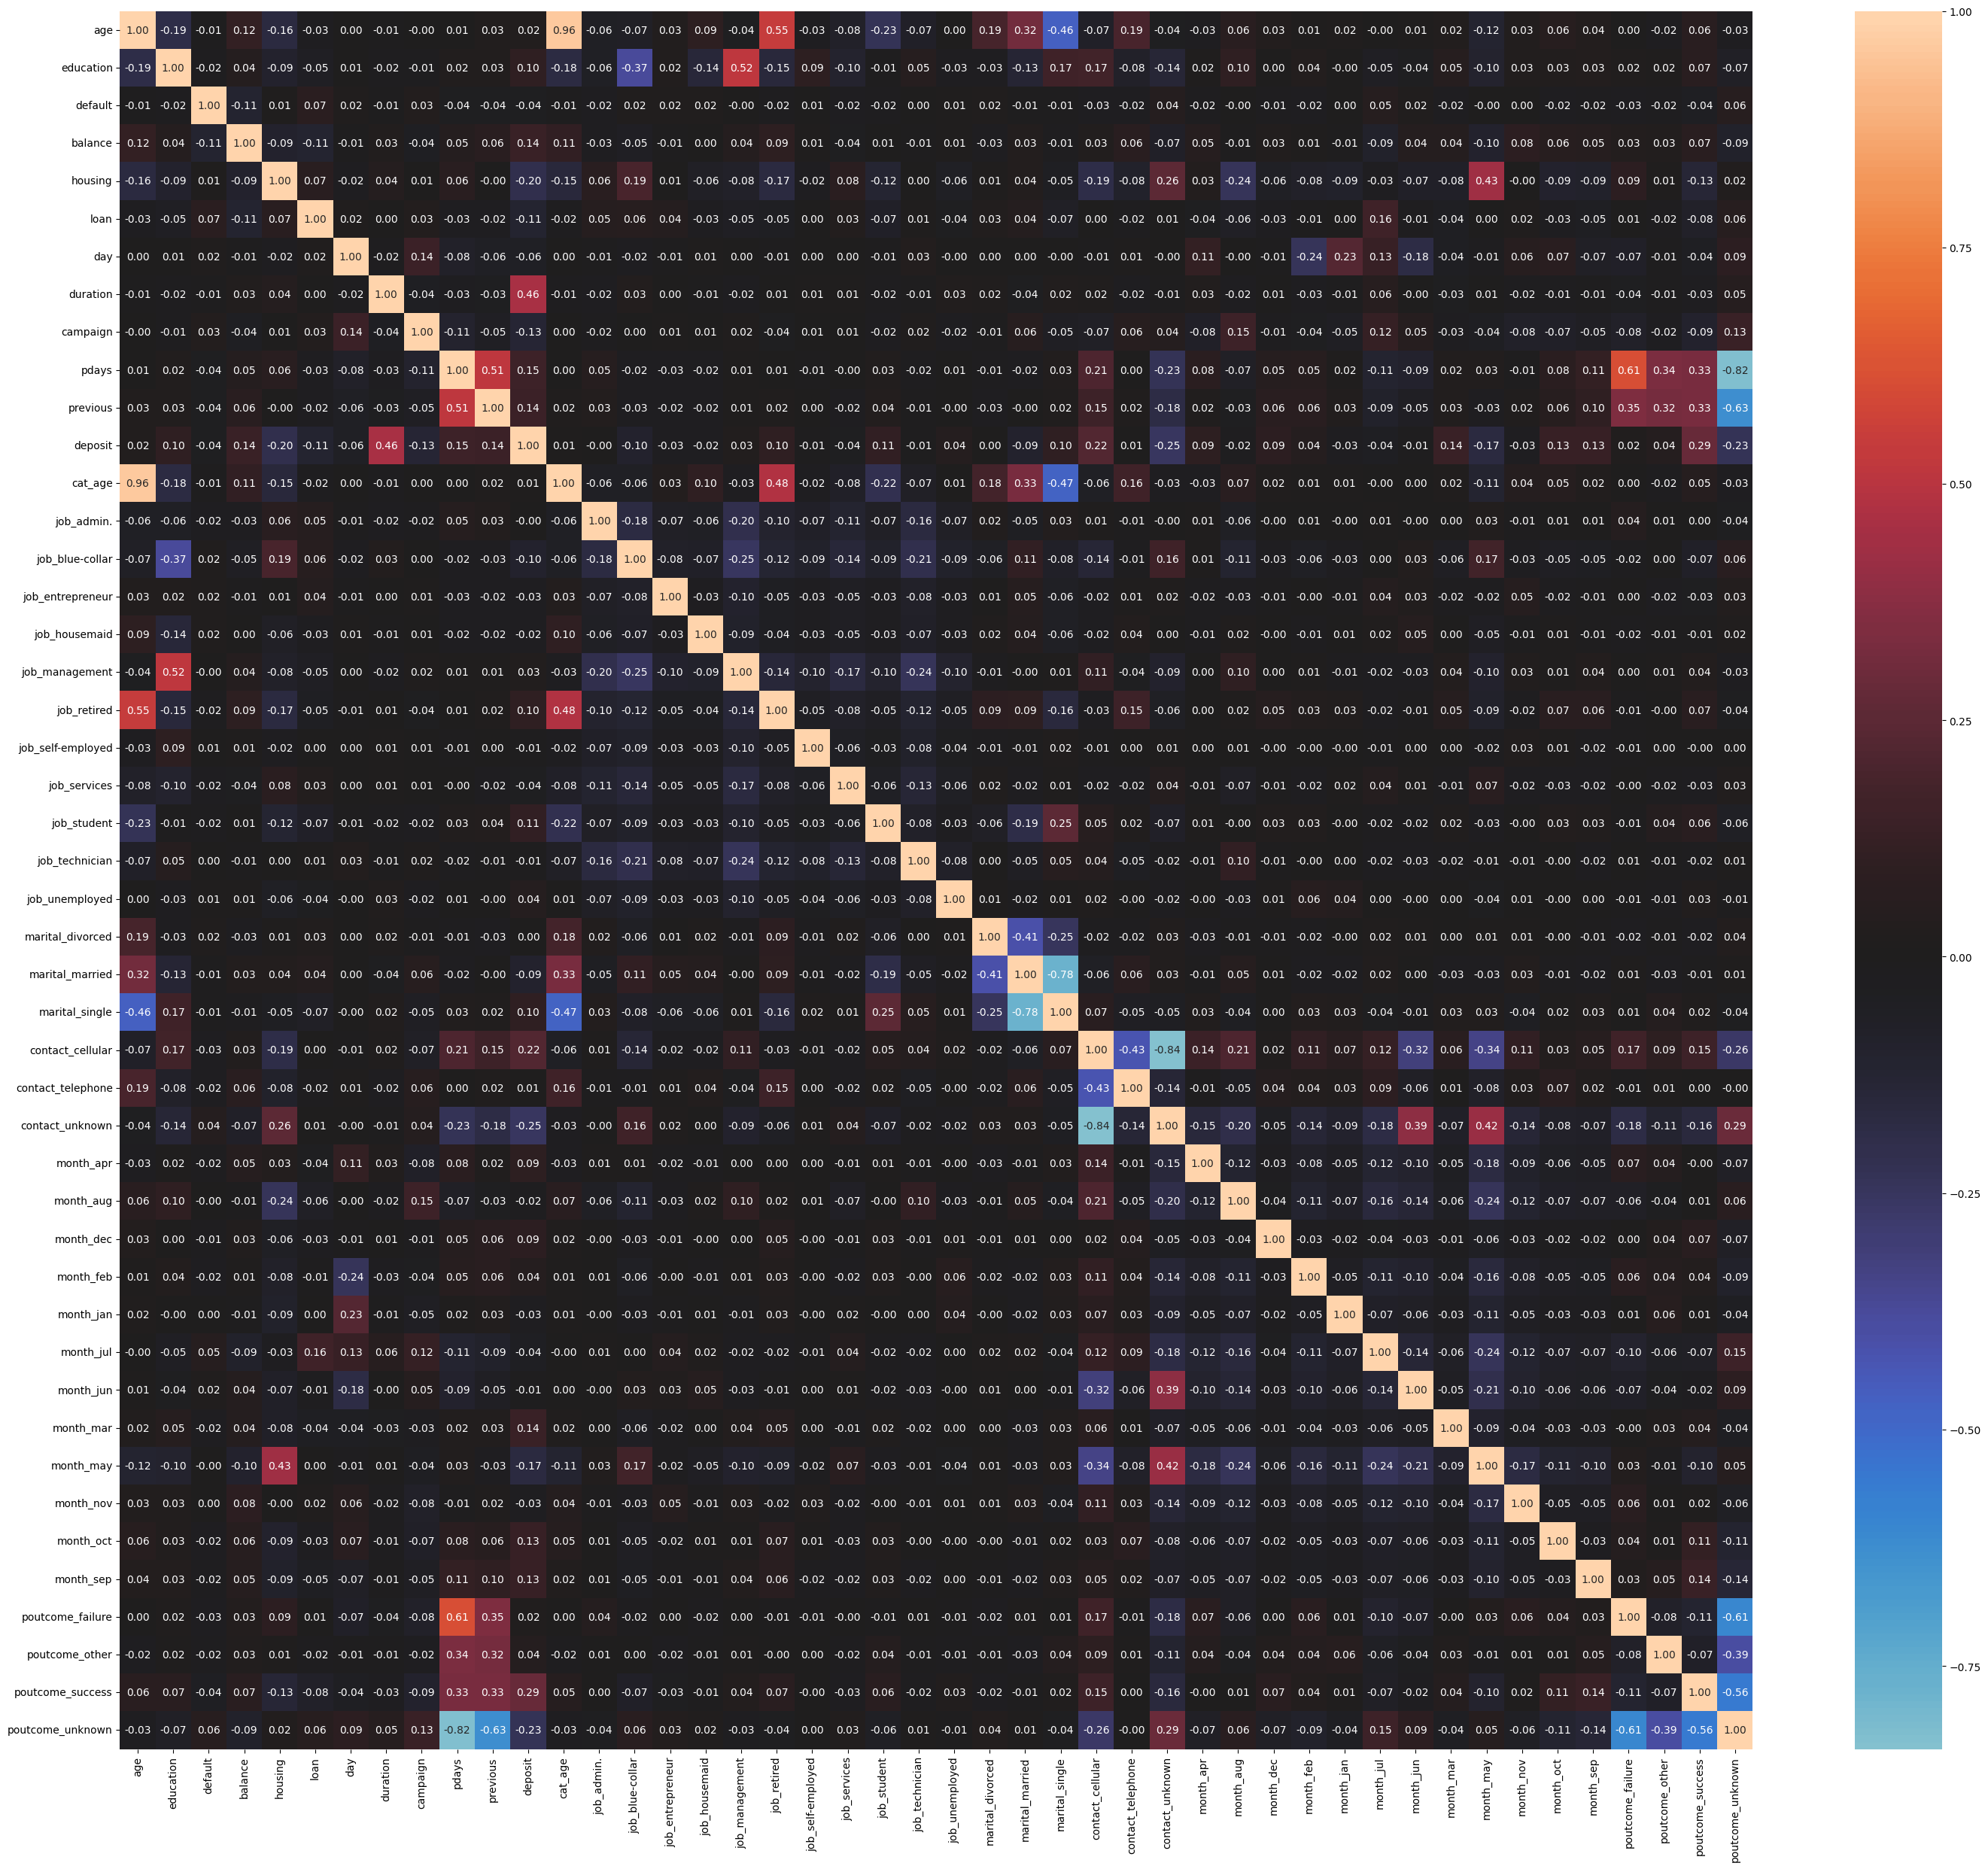

In [659]:
#Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(35,30))
sns.heatmap(df.corr(), annot=True, fmt='.2f', center=0)

Для оценки значимости признаков будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ ANOVA. Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

In [660]:
# разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией о клиентах, у - целевая переменная (депозит)
X = df.drop(['deposit'], axis = 1)
y = df['deposit']

<AxesSubplot: title={'center': 'Корреляция с целевым признаком'}>

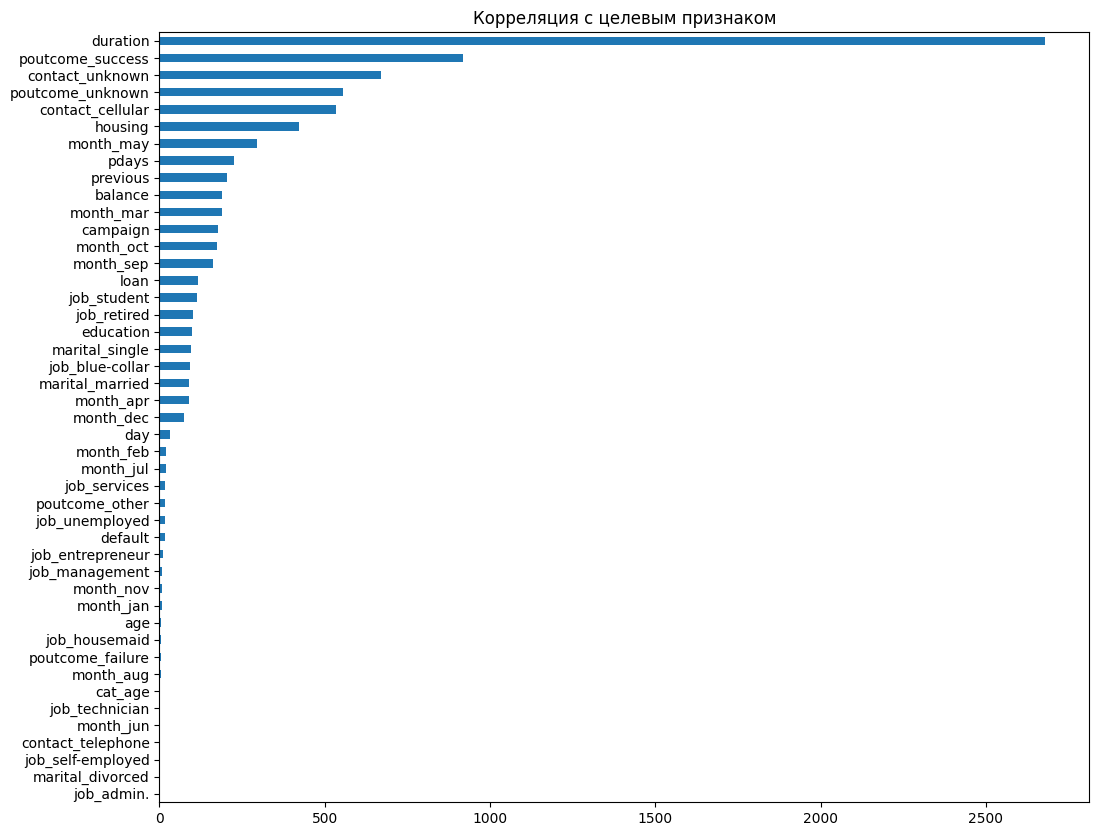

In [661]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X, y)[0], index = X.columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', figsize=(12,10), title='Корреляция с целевым признаком')

С помощью графиков мы видим, что среди признаков нет сильной мультиколлинеарности (за исключением признаков age и cat_age, что очевидно, т к это один и тот же признак), а также выделить признаки, которые являются наиболее/наименее значимыми. 

### Задания 7 и 8

In [662]:
#Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (6770, 45)
Test shape: (3335, 45)


In [663]:
X_train

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
7287,34,2,0,557.0,1,0,16,513,1,-1,...,0,0,0,0,0,0,0,0,0,1
4766,34,2,0,69.0,0,1,25,296,1,205,...,0,0,0,1,0,0,1,0,0,0
5712,33,2,0,0.0,1,0,5,399,2,358,...,0,0,1,0,0,0,0,1,0,0
2530,37,1,0,444.0,0,0,14,137,1,102,...,0,0,0,0,0,0,0,0,1,0
9294,39,1,0,1444.0,0,0,19,100,1,117,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,30,2,0,222.0,0,1,4,111,1,204,...,0,0,0,0,0,0,0,1,0,0
1056,53,1,0,1777.0,1,0,21,796,5,154,...,0,0,0,1,0,0,1,0,0,0
2931,76,0,0,3324.0,0,0,13,122,1,92,...,0,0,0,1,0,0,0,0,1,0
7735,29,1,0,209.0,0,0,5,605,2,-1,...,0,0,0,0,0,0,0,0,0,1


In [664]:
# рассчитаем необходимые показатели
round(y_test.mean(),2)

0.46

### Задание 9

In [665]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
X_train_best = selector.transform(X_train)
X_test_best = selector.transform(X_test)
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [666]:
X_train

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
7287,34,2,0,557.0,1,0,16,513,1,-1,...,0,0,0,0,0,0,0,0,0,1
4766,34,2,0,69.0,0,1,25,296,1,205,...,0,0,0,1,0,0,1,0,0,0
5712,33,2,0,0.0,1,0,5,399,2,358,...,0,0,1,0,0,0,0,1,0,0
2530,37,1,0,444.0,0,0,14,137,1,102,...,0,0,0,0,0,0,0,0,1,0
9294,39,1,0,1444.0,0,0,19,100,1,117,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,30,2,0,222.0,0,1,4,111,1,204,...,0,0,0,0,0,0,0,1,0,0
1056,53,1,0,1777.0,1,0,21,796,5,154,...,0,0,0,1,0,0,1,0,0,0
2931,76,0,0,3324.0,0,0,13,122,1,92,...,0,0,0,1,0,0,0,0,1,0
7735,29,1,0,209.0,0,0,5,605,2,-1,...,0,0,0,0,0,0,0,0,0,1


### Задание 10

In [667]:
# нормализуем данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)
round((X_test_scaled[:, 0].mean()),2)

0.31

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [669]:
# обучим логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver = 'sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print('Значение accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test_pred, y_test)))

Значение accuracy на тестовой выборке: 0.81


### Задания 2,3,4

In [670]:
#Теперь обучим ещё один алгоритм — решающие деревья
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train_scaled, y_train)
y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)
print('Значение accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train_pred_dt, y_train)))
print('Значение accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test_pred_dt, y_test)))

Значение accuracy на тренировочной выборке: 1.00
Значение accuracy на тестовой выборке: 0.79


Модель явно переобучена. Попробуем улучшить модель с помощью оптимизации параметра максимальной глубины дерева.

In [671]:
param_grid = {'max_depth': [2,3,4,5,6,7,8]}
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42), param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: user 62.5 ms, sys: 12.7 ms, total: 75.2 ms
Wall time: 311 ms
accuracy на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 8}


### Задание 5

In [672]:
# Попробуем еще улучшить модель, подберем оптимальные параметры с помощью gridsearch
estimator = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=estimator, 
    param_grid = param_grid,
    scoring=('f1'), 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_tree.predict(X_test_scaled)
#Рассчитываем F1-меру для тестовых данных
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: user 85.3 ms, sys: 16.1 ms, total: 101 ms
Wall time: 323 ms
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [673]:
# обучим на данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
    )
#Обучаем модель
rf.fit(X_train_scaled, y_train)
y_t_pred_rf = rf.predict(X_test_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)
print('Значение accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test_pred_rf, y_test)))
print('Значение recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_rf)))


Значение accuracy на тестовой выборке: 0.84
Значение recall на тестовой выборке: 0.85


### Задания 2 и 3

In [674]:
# используем для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05, 
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
    )
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
print('Значение accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_pred_gb, y_test)))
print('Значение recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_pred_gb)))
print('Значение f1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_pred_gb)))


Значение accuracy на тестовой выборке: 0.86
Значение recall на тестовой выборке: 0.88
Значение f1 на тестовой выборке: 0.85


### Задание 4

In [675]:
# А теперь объединим уже известные нам алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', log_reg),
    ('dt', dt),
    ('gb', gb)
]

# Создаем объект класса стекинг
st = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, solver = 'sag', max_iter=1000)
)
# Обучаем модель
st.fit(X_train_scaled, y_train)
y_pr_stack = st.predict(X_test_scaled)
print('Значение f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pr_stack)))
print('Значение recall на тестовом наборе:: {:.2f}'.format(metrics.recall_score(y_test, y_pr_stack)))
print('Значение precision на тестовой выборке: {:.2f}'.format(metrics.precision_score(y_test, y_pr_stack)))

Значение f1 на тестовом наборе: 0.84
Значение recall на тестовом наборе:: 0.86
Значение precision на тестовой выборке: 0.83


### Задание 5

In [684]:
# Выберем три признака, дающих наибольший вклад,
# Для того, чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns) 

estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

In [685]:
estimator = gb
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [688]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса.
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
# напрямую указываем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2024-01-10 12:44:41,318] A new study created in memory with name: RandomForestClassifier
[I 2024-01-10 12:44:42,216] Trial 0 finished with value: 0.9275407292474787 and parameters: {'n_estimators': 187, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9275407292474787.
[I 2024-01-10 12:44:42,763] Trial 1 finished with value: 0.8695919938414166 and parameters: {'n_estimators': 144, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9275407292474787.
[I 2024-01-10 12:44:43,388] Trial 2 finished with value: 0.9098873591989988 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9275407292474787.
[I 2024-01-10 12:44:44,166] Trial 3 finished with value: 0.8908215561422581 and parameters: {'n_estimators': 191, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9275407292474787.
[I 2024-01-10 12:44:44,996] Trial 4 finished with value: 0.8835489833641405 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 168, 'max_depth': 21, 'min_samples_leaf': 2}


In [690]:
# рассчитаем метрики для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.84


Нам удалось улучшить модель и добиться хорошего результата.